# 5. Capstone Project: Machine Learning Models IV

***

![headerall](./images/headers/header_all.jpg)

##  Goals

### Project:
In this work, we will first analyze where and when traffic congestion is highest and lowest in New York State. We will then build different machine learning models capable of predicting cab travel times in and around New York City using only variables that can be easily obtained from a smartphone app or a website. We will then compare their performance and explore the possibility of using additional variables such as weather forecasts and holidays to improve the predictive performance of the models.

### Section:
In this section, we will use the knowledge gained during the exploratory data analysis to perform the final feature transformation. Next, we will create and compare the performance of several machine learning models, namely: linear regressions, a support vector machine regressor, a random forest regressor and a gradient boosted decision tree. The feature space and hyperparameters will be optimised for each model to obtain the best possible performance.

## Data
### External Datasets:
- Weather Forecast: The 2018 NYC weather forecast was collected from the [National Weather Service Forecast Office](https://w2.weather.gov/climate/index.php?wfo=okx) website. Daily measurements were taken from January to December 2018 in Central Park. These measures are given in imperial units and include daily minimum and maximum temperatures, precipitations, snowfall, and snow depth.

- Holidays: The 2018 NYC holidays list was collected from the [Office Holiday](https://www.officeholidays.com/countries/usa/new-york/2021) website. The dataset contains the name, date, and type of holidays for New York.

- Taxi Zones: The NYC Taxi Zones dataset was collected from the [NYC Open Data](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) website. It contains the pickup and drop-off zones (Location IDs) for the Yellow, Green, and FHV Trip Records. The taxi zones are based on the NYC Department of City Planning’s Neighborhood.

### Primary Datasets:

- Taxi Trips: The 2018 NYC Taxi Trip dataset was collected from the [Google Big Query](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips?project=jovial-monument-300209&folder=&organizationId=) platform. The dataset contains more than 100'000'000 Yellow Taxi Trip records for 2018 and contains an extensive amount of variables including the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

***
## Table of Content:
    1. Data Preparation
        1.1 External Datasets
            1.1.1 Weather Forecast Dataset
            1.1.2 Holidays Dataset
            1.1.3 Taxi Zones Dataset
        1.2 Primary Dataset
            1.2.1 Taxi Trips Dataset
            1.2.2 Taxi Trips Subset
    2. Exploratory Data Analysis
        2.1 Primary Dataset
            2.1.1 Temporal Analysis
            2.1.2 Spatio-Temporal Analysis
        2.2 External Datasets
            2.2.1 Temporal Analysis of Weather Data
            2.2.2 Temporal Analysis of Holidays Data
        2.3 Combined Dataset
            2.3.1 Overall Features Correlation
    3. Machine Learning Models
        3.1 Data Preparation
        3.2 Baselines
        3.3 Model Training
            3.3.1 Linear Regression
            3.3.2 Support Vector Machine
            3.3.3 Random Forest
            3.3.4 Gradient Boosted Decision Tree
        3.4 Final Models Comparison
    4. Conclusions

***
## Python Libraries and Magic Commands Import

In [1]:
# Import python core libraries
import time

# Import data processing libraries gpd
import pandas as pd
import numpy as np

# Import Visualization libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# Import machine learning libraries
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE 

In [2]:
# Set up magic commands
%matplotlib inline
%config Completer.use_jedi = False

***

## Data Import

In [3]:
# Import the train dataset
train_df = pd.read_pickle(r'data/processed/train.pickle')

# Get the independant variables from the train dataset
X_tr = train_df.drop("trip_duration", axis=1)

# Get the dependant variable from the train dataset
y_tr = train_df["trip_duration"]

print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape, y_tr.dtype)

X_tr: (824654, 33)
y_tr: (824654,) float64


In [4]:
# Import the test dataset
test_df = pd.read_pickle(r'data/processed/test.pickle')

# Get the independant variables from the test dataset
X_te = test_df.drop("trip_duration", axis=1)

# Get the dependant variable from the test dataset
y_te = test_df["trip_duration"]

print('X_te:', X_te.shape)
print('y_te:', y_te.shape, y_te.dtype)

X_te: (206156, 33)
y_te: (206156,) float64


In [5]:
# Get id column names from the train dataset
id_cols = [c for c in train_df.columns if "_id" in c]

# Remove ID features in the train dataset
X_tr.drop(id_cols, axis=1, inplace=True)

# Remove ID features in the test dataset
X_te.drop(id_cols, axis=1, inplace=True)

# Drop the pickup day of the year variable from the train dataset
X_tr.drop("pickup_yearday", axis=1, inplace=True)

# Drop the pickup day of the year variable from the test dataset
X_te.drop("pickup_yearday", axis=1, inplace=True)

***
## Functions Import

In [6]:
# Define a function that display individual barplot
def plot_barplot(
    data,
    x_var,
    y_var,
    xlabel,
    ylabel,
    title="",
    labels=None,
    label_order=None,
    legend=None,
    figsize=(20, 5),
    palette="YlGnBu",
):
    # Create a figure with one column and row
    fig, ax = plt.subplots(figsize=figsize)

    # Generate the plot
    if labels == None:
        sns.barplot(
            x=x_var,
            y=y_var,
            data=data,
            ax=ax,
            palette=palette,
        )
    else:
        sns.barplot(
            x=x_var,
            y=y_var,
            hue=labels,
            hue_order=label_order,
            data=data,
            ax=ax,
            palette=palette,
        )
        ax.legend(title=legend)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_ticks_position("none")
    ax.tick_params(labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()

    # Adjust the padding between and around subplots
    fig.tight_layout(pad=0.5, w_pad=0.5)

    # Add a title to the figure
    plt.title(title.title(), fontsize=18, pad=15)
    
    # Display the figure
    plt.show()

***
## 3.3.3 Model Training: Random Forest Regressor

## Goals:
Train and optimise random forest regressor models

## Code:

###  Random Forest: testing different training sizes

In [7]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr[:100], y_tr[:100])

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time_1 = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time_1))

The MSE of the Random Forest regression model is: 35.0
The MAE of the Random Forest regression model is: 3.0

(Exectution time: 1.3 sec)


In [8]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr[:1000], y_tr[:1000])

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time_2 = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time_2))

The MSE of the Random Forest regression model is: 28.1
The MAE of the Random Forest regression model is: 2.5

(Exectution time: 2.3 sec)


In [9]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr[:10000], y_tr[:10000])

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time_3 = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time_3))

The MSE of the Random Forest regression model is: 21.5
The MAE of the Random Forest regression model is: 2.2

(Exectution time: 7.5 sec)


In [10]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr[:100000], y_tr[:100000])

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time_4 = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time_4))

The MSE of the Random Forest regression model is: 17.7
The MAE of the Random Forest regression model is: 2.0

(Exectution time: 57.1 sec)


In [11]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 15.4
The MAE of the Random Forest regression model is: 1.8

(Exectution time: 652.0 sec)


**Notes:** The training time of a random forest regressor increases quadratically with the sample size. Training the model on the full data set takes about 10 minutes. Further tests will thus be carried out on a 10% subset when required.

###  Random Forest: testing different feature spaces

In [12]:
# Create a subset of the train matrix without holiday data
X_tr_sub1 = X_tr.drop(columns=[col for col in X_tr.columns if "holiday" in col])

# Create a subset of the test matrix without holiday data
X_te_sub1 = X_te.drop(columns=[col for col in X_te.columns if "holiday" in col])

print("X_tr:", X_tr_sub1.shape)
print("X_te:", X_te_sub1.shape)

X_tr: (824654, 26)
X_te: (206156, 26)


In [13]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model_sub = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model_sub.fit(X_tr_sub1, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model_sub.predict(X_te_sub1)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 15.5
The MAE of the Random Forest regression model is: 1.8

(Exectution time: 612.7 sec)


In [14]:
# Create a subset of the train matrix without weather forecast data
X_tr_sub2 = X_tr.drop(columns=[col for col in X_tr.columns if "wf" in col])

# Create a subset of the test matrix without weather forecast data
X_te_sub2 = X_te.drop(columns=[col for col in X_te.columns if "wf" in col])

print("X_tr:", X_tr_sub2.shape)
print("X_te:", X_te_sub2.shape)

X_tr: (824654, 20)
X_te: (206156, 20)


In [15]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model_sub = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the prerocessed train dataset
rf_model_sub.fit(X_tr_sub2, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model_sub.predict(X_te_sub2)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 15.6
The MAE of the Random Forest regression model is: 1.8

(Exectution time: 453.9 sec)


In [16]:
# Create a subset of the train matrix without holiday and weather forecastdata
X_tr_sub3 = X_tr.drop(columns=[col for col in X_tr.columns if "wf" in col or "holiday" in col])
                               
# Create a subset of the test matrix without holiday and weather forecast data
X_te_sub3 = X_te.drop(columns=[col for col in X_te.columns if "wf" in col or "holiday" in col])

print("X_tr:", X_tr_sub3.shape)
print("X_te:", X_te_sub3.shape)

X_tr: (824654, 18)
X_te: (206156, 18)


In [17]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model_sub = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model_sub.fit(X_tr_sub3, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model_sub.predict(X_te_sub3)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 15.9
The MAE of the Random Forest regression model is: 1.8

(Exectution time: 423.9 sec)


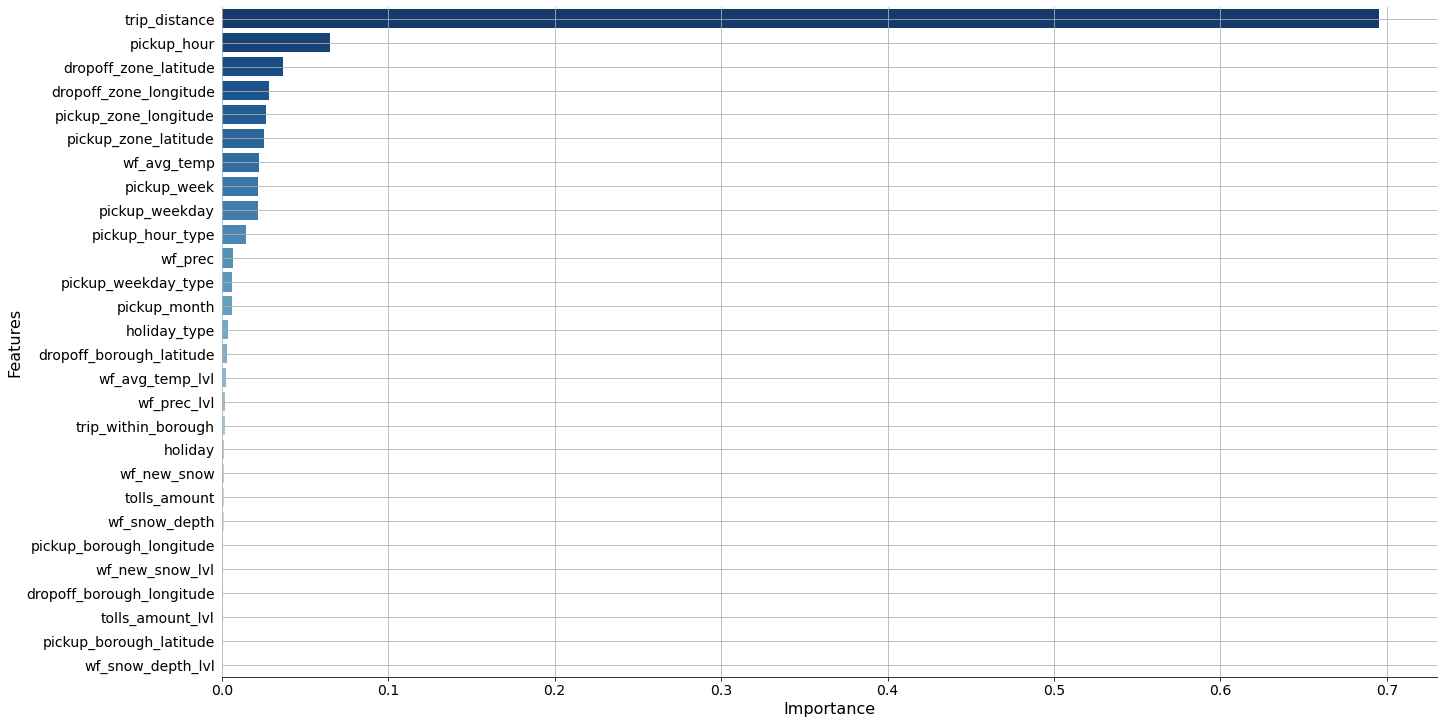

In [18]:
# Create a new dataframe with the features importance
features_imp_df = pd.DataFrame({
    'features':X_tr.columns,
    'importance':rf_model['randomforestregressor'].feature_importances_
})

# Sort feature by importance in the data frame
features_imp_df.sort_values('importance', ascending=False, inplace=True)

# Display the feature importance in an horizontal barplot
plot_barplot(
   features_imp_df,
    'importance',
    'features',
    xlabel='Importance',
    ylabel='Features',
    figsize=(20, 10),
    palette="Blues_r"
)

In [19]:
# Create a subset of the train matrix without holiday and weather forecastdata
X_tr_sub4 = X_tr[features_imp_df.features[:13].to_list()]
                               
# Create a subset of the test matrix without holiday and weather forecast data
X_te_sub4 = X_te[features_imp_df.features[:13].to_list()]

print("X_tr:", X_tr_sub4.shape)
print("X_te:", X_te_sub4.shape)

X_tr: (824654, 13)
X_te: (206156, 13)


In [20]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model_sub = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model_sub.fit(X_tr_sub4, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model_sub.predict(X_te_sub4)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 15.7
The MAE of the Random Forest regression model is: 1.8

(Exectution time: 440.4 sec)


**Notes:** Reducing the feature space by removing non-core variables does not affect performance, but significantly reduces computation time. It can also results in a more accurate and interpretable model.

###  Random Forest: testing dimensionality reduction with PCA

In [21]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 16.8
The MAE of the Random Forest regression model is: 1.9

(Exectution time: 1593.3 sec)


In [22]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.99),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 16.2
The MAE of the Random Forest regression model is: 1.9

(Exectution time: 2074.0 sec)


In [23]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr_sub4, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te_sub4)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 21.1
The MAE of the Random Forest regression model is: 2.3

(Exectution time: 1196.8 sec)


In [24]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.99),
    RandomForestRegressor(random_state=0)
)

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr_sub4, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te_sub4)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

The MSE of the Random Forest regression model is: 16.9
The MAE of the Random Forest regression model is: 1.9

(Exectution time: 1246.1 sec)


**Notes:** Reducing the feature space with principal component analysis (PCA) worsens the performance of the models.

###  Random Forest: testing different hyperparameters

In [25]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=0)
)

# Define a set of hyperparameters to be tested during gridsearch
rf_model_params = {
    'randomforestregressor__max_depth': [None]+ np.arange(1, 27, 5, dtype='int').tolist(),
    'randomforestregressor__n_estimators': np.logspace(1, 3, 6, dtype='int'),
}

# Create a gridsearch object to find the optimum hyperparameters
rf_model_gs = GridSearchCV(
    rf_model,
    rf_model_params,
    cv=3,
    return_train_score=True,
    verbose=True,
    n_jobs=-1,
)

# Fit and evaluate the pipeline to 10 percent of the preprocessed train dataset
rf_model_gs.fit(X_tr_sub4[:82465], y_tr[:82465])

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model_gs.predict(X_te_sub4)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print("\n The best parameters across all searched params: \n", rf_model_gs.best_params_)
print('\n(Exectution time: {:.1f} sec)'.format(end_time))

Fitting 3 folds for each of 42 candidates, totalling 126 fits
The MSE of the Random Forest regression model is: 18.1
The MAE of the Random Forest regression model is: 2.0

 The best parameters across all searched params: 
 {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 1000}

(Exectution time: 1437.9 sec)


**Notes:**

It is usually suggested to use linear kernels if the number of features is larger than the number of observations in the dataset (otherwise RBF might be a better choice). When working with a large amount of data using RBF, speed might become a constraint to take into account.

###  Random Forest: final results

In [ ]:
# Get time at exectution start
start_time = time.time()

# Create a pipeline that performs standardization and fit the data to a Random Forest model
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(
        max_depth=None,
        n_estimators=1000,
        random_state=0
))

# Fit and evaluate the pipeline to the preprocessed train dataset
rf_model.fit(X_tr, y_tr)

# Predict the target variable of the preprocessed test dataset with the best hyperparameters 
rf_y_pred = rf_model.predict(X_te)

# Calculate execution time
end_time = time.time() - start_time

print('The MSE of the Random Forest regression model is: {:.1f}'.format(MSE(y_te, rf_y_pred)))
print('The MAE of the Random Forest regression model is: {:.1f}'.format(MAE(y_te, rf_y_pred)))

print('\n(Exectution time: {:.1f} sec)'.format(end_time))

***
## Export Files

In [ ]:
# Create a new data frame containing the MSE and MAE of the model
rf_results = pd.DataFrame({
    'model':['rf'],
    'mse':[MSE(y_te, rf_y_pred)],
    'mae':[MAE(y_te, rf_y_pred)],
})

# Save the results in the project folder
rf_results.to_csv('results/rf_model.csv', index=False)